In [27]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

#Cython

How to speed up your python code.

http://docs.cython.org/index.html
http://docs.cython.org/src/userguide/language_basics.html#language-basics
http://docs.cython.org/src/tutorial/numpy.html
http://docs.cython.org/src/tutorial/array.html

One of the main reason for python slowness is that it needs to check for type all the time.

For example:

    a=3
    b=4
    c = a+b

when we do the addition python check the type of `a` and `b` and call appropriate `a.__add__` function in run time. Plus, by calling function `__add__`. It needs to call `Integer.__add__`. To call `__add__` it need to do dictionary look up for the string `"__add__"` in the list of method from `a` among a bunch of other things.

Long story short, it does a lot of wasteful moves since python allow you to do so many things. Things would be must faster/simple if python can take advantage of type declarations while maintaining the simplicity of python language.

There are two ways to do that first method is Cython which allow you to write a Python-like code then cython convert it to highly optimize C/C++ code. The C code is then compiled and linked against python. So we can load it as a module to use in python code.

The other way is using JIT(Just in time compiler). This allows you to just write normal python code. JIT analyze your code and figure out the type at run time to speed up the executiion. We will not cover that here.

In [28]:
a=3
a.__add__(2)

5

##Basic

In [29]:
%load_ext Cython
#older version may need to do %load_ext cythonmagic

In [30]:
%%cython
#anything in this cell is cython code and will be execute as such
#Yes, for most part it's just python code
a = 1
b = 3
print a+b

4


In [31]:
%%cython
#Let's do something more fun
def sumsquare(n):
    s = 0.0
    for i in range(n):
        s+=i**2
    return s

In [32]:
#Yes It's exactly the same
def pysumsquare(n):
    s = 0.0
    for i in range(n):
        s+=i**2
    return s

##timeit to measure speed.

In [33]:
#without changing any of our code 2x improvement
%timeit sumsquare(1000)
%timeit pysumsquare(1000)

10000 loops, best of 3: 81.9 µs per loop
10000 loops, best of 3: 124 µs per loop


In [34]:
#There are many flags you can control how it measure the time. (Google up)
%timeit -n 100 sumsquare(1000)
%timeit -n 100 pysumsquare(1000)

100 loops, best of 3: 92.8 µs per loop
100 loops, best of 3: 125 µs per loop


In [35]:
%%timeit -n 10
#there is a block version of timeit too. Just use double percent.
#I don't really like this one but it's good for quick test
a=0
for i in range(20):
   a+=i**2
print a,

2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 2470 247010 loops, best of 3: 31.6 µs per loop



##Declaring Types

Let us speed it up further by telling the type using cdef.

In [ ]:
%%cython
#the code still looks very readable.
def sumsquare_withtype(int n): #<<<here
    cdef float s = 0.0 #<<here
    cdef int i = 0 #<< and here
    for i in range(n):
        s+=i**2
    return s

In [ ]:
#another 65x. by adding couple lines.
#So you just speed it up by 150x by adding a couple lines. Magic!!!
%timeit sumsquare(1000)
%timeit sumsquare_withtype(1000)
%timeit pysumsquare(1000)

###Pydoc
Good code comes with doc.

In [ ]:
def f(x,y):
    """
    f(x,y) -> x+y
    add two numbers
    """
    return x+y

In [ ]:
#type f( and shift+tab works too
?f

In [ ]:
%%cython
def cyf(int x,int y):
    """
    cyf(x,y)
    add two numbers
    """
    return x+y

In [ ]:
#there
?cyf

###Annotations
Let us learn how to write a good cython code using annotations. By adding -a to %%cython, it generates a nice html for us to see what kind of C code. It's generated. The color code is <span style="color:GoldenRod">Python call</span> in yellow, and white means good C code. Our goal is to get as much white as possible especially in the tight loop. You can also click on each line to see what C code it generated.

The yellow in the first and the last line we can't do anything with it.

In [ ]:
%%cython -a
#Let's do something more fun
def sumsquare(n):
    s = 0.0
    for i in range(n):
        s+=i**2
    return s

In [ ]:
%%cython -a
#Let's do something more fun
def sumsquare_withtype(int n): #<<<here
    cdef float s = 0.0 #<<here
    cdef int i = 0 #<< and here
    for i in range(n):
        s+=i**2
    return s

####Exercise 
1) write py_isPrime(x)

In [ ]:
import math
def py_isPrime(x):
    l = int(math.ceil(math.sqrt(x)))
    if x%2==0:
        return False
    for i in range(3,l+1,2): #from 3,5,7...to sqrt(x)
        if x%i == 0:
            return False
    return True

2) Now write a cython version. (Note the annotation is a guideline. Some yellow is unavoidable)

In [ ]:
%%cython -a
from libc.math cimport ceil, sqrt #use libc math not python math
def cy_isPrime(int x):
    cdef int l = <int>sqrt(x)
    cdef int i = 0
    if x%2==0:
        return False
    for i in range(3,l+1,2): #from 2...to sqrt(x)
        if x%i == 0:
            return False
    return True

In [ ]:
print cy_isPrime(3)

In [ ]:
%timeit -n 100 py_isPrime(999983)
%timeit -n 100 cy_isPrime(999983)

###Profiling
Let us write nPrimes which return prime up to n and let us see what is the bottle neck with %prun.

In [ ]:
import math
def py_isPrime(x):
    l = int(math.ceil(math.sqrt(x)))
    if x==2:
        return True
    elif x%2==0:
        return False
    
    for i in range(3,l+1,2): #from 3,5,7...to sqrt(x)
        if x%i == 0:
            return False
    return True

def py_primeCount(n):
    count = 0
    if n>=2:
        count +=1
    for i in range(3,n+1,2):
        if py_isPrime(i):
            count+=1
    return count

In [ ]:
print py_isPrime(2)
print py_isPrime(3)

In [ ]:
print py_primeCount(10000)

In [ ]:
%timeit py_primeCount(10000)

In [ ]:
%prun py_primeCount(10000)

In [ ]:
#you can see the the bottle neck is in isPrime it's called a lot and takes a lot of time

Let us use cython version of isPrime. You can see that the time is cut by a half.
If I'm in rush, I'd just stop here.

In [ ]:
def py_primeCount2(n):
    count = 0
    if n>=2:
        count +=1
    for i in range(3,n+1,2):
        if cy_isPrime(i):
            count+=1
    return count  

In [ ]:
%timeit py_primeCount2(10000)

In [ ]:
%prun py_primeCount2(10000)

###function declaration def cdef cpdef

How about using both function as cython. There are three ways to do it: def cdef cpdef.

`def` is just for normal python function.

`cdef` is like declaring a c function. So other function in cython doesn't have to do name look up. This however has some restriction like return type etc and the function can't be called from python.

`cpdef` generates both `def` and `cdef` version. Cython takes care of calling the appropriate one.

In [36]:
%%cython -a
from libc.math cimport ceil, sqrt #use libc math not python math
def cy_isPrime(int x):
    cdef int l = <int>sqrt(x)
    cdef int i = 0
    if x==2:
        return True
    elif x%2==0:
        return False
    
    for i in range(3,l+1,2): #from 2...to sqrt(x)
        if x%i == 0:
            return False
    return True

def cy_primeCount(int n):
    cdef int count = 0
    cdef int i
    if n>=2:
        count +=1
    for i in range(3,n+1,2):
        if cy_isPrime(i):
            count+=1
    return count

In [37]:
%timeit cy_primeCount(10000)

1000 loops, best of 3: 449 µs per loop


Python function is very expensive since it has to do name lookup for appropriate function. Unlike C, Python doesn't just jump to specific function which was determine at run time. Python look up the name findout where is the funtion at runtime. This is necessary since you can keep redifining function at run time.

In [ ]:
%%cython -a
from libc.math cimport ceil, sqrt #use libc math not python math
cdef bint cy_cdef_isPrime(int x):
    cdef int l = <int>sqrt(x)
    cdef int i = 0
    if x%2==0:
        return False
    for i in range(3,l+1,2): #from 2...to sqrt(x)
        if x%i == 0:
            return False
    return True

def cy_cdef_primeCount(int n):
    cdef int count = 0
    cdef int i
    if n>=2:
        count +=1
    for i in range(3,n+1,2):
        if cy_cdef_isPrime(i):
            count+=1
    return count

In [ ]:
%timeit cy_cdef_primeCount(10000)

In [ ]:
#however cdef function is not defined outside
#uncomment this line it will say the function is undefined.
#cy_cdef_isPrime

In [ ]:
%%cython -a
import math
from libc.math cimport ceil, sqrt #use libc math not python math
cpdef bint cy_cpdef_isPrime(int x):
    cdef int l = <int>sqrt(x)
    cdef int i = 0
    if x%2==0:
        return False
    for i in range(3,l+1,2): #from 2...to sqrt(x)
        if x%i == 0:
            return False
    return True

def cy_cpdef_primeCount(int n):
    cdef int count = 0
    cdef int i
    if n>=2:
        count +=1
    for i in range(3,n+1,2):
        if cy_cpdef_isPrime(i):
            count+=1
    return count

In [ ]:
%timeit cy_cpdef_primeCount(10000)

In [ ]:
#and the function is defined outside
cy_cpdef_isPrime(999983)

In [ ]:
#35x speed up
print 10e-3/279e-6

###List, Array Vector etc.

Having a good compiler is not an excuse for writing a crappy algorithm. You may have notice that when we look for prime we only need to check for the divisibility of the previous prime.

In [ ]:
from math import sqrt
def goodPrimeCount(n):
    count = 0
    prime_so_far = [2]
    if n>=2:
        count +=1
    for i in range(3,n,2):
        found_prime = True
        sqrti = math.sqrt(i)
        for p in prime_so_far:
            if i%p==0:
                found_prime = False
                break #for p
            if p>sqrti:
                break #for p
        if found_prime:
            prime_so_far.append(i)
            count+=1
    return count       

In [ ]:
%timeit py_primeCount(10000)
%timeit py_primeCount2(10000)
%timeit cy_cpdef_primeCount(10000)
%timeit goodPrimeCount(10000)

In [ ]:
print py_primeCount(10000)
print py_primeCount2(10000)
print cy_cpdef_primeCount(10000)
print goodPrimeCount(10000)

In [ ]:
%%cython -a
from libc.math cimport sqrt

def cy_goodPrimeCount_withlist(int n):
    cdef int count = 0
    cdef list prime_so_far = [2]
    cdef int i, p
    if n>=2:
        count +=1
    for i in range(3,n,2):
        found_prime = True
        sqrti = sqrt(i)
        for p in prime_so_far:
            if i%p==0:
                found_prime = False
                break #for p
            if p>sqrti:
                break #for p
        if found_prime:
            prime_so_far.append(i)
            count+=1
    return count   

In [ ]:
%timeit goodPrimeCount(10000)
%timeit cy_goodPrimeCount_withlist(10000)

###Exercise

Euler conjecture. You probably have seen this one before.
http://www.ams.org/journals/bull/1966-72-06/S0002-9904-1966-11654-3/S0002-9904-1966-11654-3.pdf

Optimize this and cythonize the code

In [38]:
#Python version
#a^5 + b^5 + c^5 + d^5 = e^5 
def euler_conjecture():
    for a in range(1,200):
        a5 = a**5
        print a,
        for b in range(a,200):
            b5 = b**5
            for c in range(b,200):
                c5 = c**5
                for d in range(c,200):
                    d5= d**5
                    tmp = a5 + b5 + c5 + d5  
                    for e in range(d,200):
                        e5=e**5
                        if e5==tmp:
                            return a,b,c,d,e
                        if e5>tmp:
                            break
    return False          

In [39]:
#Protips: Kernel Interrupt to stop it
euler_conjecture()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21

KeyboardInterrupt: 

In [ ]:
%%cython -a
def cy_euler_conjecture():
    cdef long a,b,c,d,e,a5,b5,c5,d5,e5
    for a in range(1,200):
        a5 = a**5
        print a,
        for b in range(a,200):
            b5 = b**5
            for c in range(b,200):
                c5 = c**5
                for d in range(c,200):
                    d5= d**5
                    tmp = a5 + b5 + c5 + d5  
                    for e in range(d,200):
                        e5=e**5
                        if e5==tmp:
                            return a,b,c,d,e
                        if e5>tmp:
                            break
    return False    


In [ ]:
cy_euler_conjecture()

###C++ vector
Python list is usually quite slow. If you need dynamic array, you are normally better off with C++ vector and such.

For static size, use numpy or c array. C++ stdlib has stuff like stack, que, map, etc.

http://docs.cython.org/src/userguide/wrapping_CPlusPlus.html#standard-library

http://docs.cython.org/src/reference/compilation.html

In [ ]:
%%cython -a --cplus
#cython: cdivision=True
#notice you need --cplus flag to use it with c++ library
#the thing in cython is called compiler directive for example the
#cdivision=True force the usage of C division without checking for zero
#doesn't really worth it though.

from libc.math cimport sqrt
from libcpp.vector cimport vector
def cy_goodPrimeCount_withvector(int n):
    cdef int count = 0
    cdef vector[int] prime_so_far
    cdef int i, p
    prime_so_far.push_back(2) #add 2 to the list
    if n>=2:
        count +=1
    for i in range(3,n,2):
        found_prime = True
        sqrti = sqrt(i)
        for p in prime_so_far:
            if i%p==0:
                found_prime = False
                break #for p
            if p>sqrti:
                break #for p
        if found_prime:
            prime_so_far.push_back(i) #<<< vector use push_back
            count+=1
    return count 

In [ ]:
print goodPrimeCount(10000)
print cy_goodPrimeCount_withlist(10000)
print cy_goodPrimeCount_withvector(10000)

In [ ]:
%timeit py_primeCount(10000)
%timeit py_primeCount2(10000)
%timeit cy_cpdef_primeCount(10000)
%timeit goodPrimeCount(10000)
%timeit cy_goodPrimeCount_withlist(10000)
%timeit cy_goodPrimeCount_withvector(10000)

###Numpy array

More often than not when we do signal processing or data analysis we work with numpy array. 

In [ ]:
import numpy as np
n = 1000
a = np.arange(n**2,dtype=float).reshape(n,n)
print a


In [ ]:
def py_sumall(a):
    s = 0.
    nrow, ncol = a.shape
    for irow in range(nrow):
        for icol in range(ncol):
            s+=a[irow, icol]
    return s

In [ ]:
%timeit py_sumall(a)

In [ ]:
%%cython -a
def cy_sumall(double[:,:] a): #numpy float is cython double. Yep....
    cdef double s = 0.
    cdef size_t nrow, ncol #yah you would have imagine int but you need size_t
    cdef int irow, icol
    cdef double t
    nrow = a.shape[0]
    ncol = a.shape[1]
    for irow in range(nrow):
        for icol in range(ncol):
            t = a[irow, icol]
            s+=t
    return s

#remember cache miss from system programming?
#numpy put these numbers in contiguous array
def cy_sumall2(double[:,:] a): #numpy float is cython double. Yep....
    cdef double s = 0.
    cdef size_t nrow, ncol #yah you would have imagine int but you need size_t
    cdef int irow, icol
    cdef double t
    nrow = a.shape[0]
    ncol = a.shape[1]
    for icol in range(ncol):
        for irow in range(nrow):
            t = a[irow, icol]
            s+=t
    return s

In [ ]:
%timeit py_sumall(a)
%timeit cy_sumall(a)
%timeit cy_sumall2(a)
%timeit np.sum(a)
#2-3 times np.sum not bad.

In [ ]:
%%cython -a
import numpy as np
# "cimport" is used to import special compile-time information
# about the numpy module (this is stored in a file numpy.pxd which is
# currently part of the Cython distribution).
cimport numpy as np
#replace some of numpy stuff with optimized version

def cy_sumall3(np.ndarray a): #without the type information numpy is not so good with index
    cdef double s = 0.
    cdef size_t nrow, ncol #yah you would have imagine int but you need size_t
    cdef int irow, icol

    nrow = a.shape[0]
    ncol = a.shape[1]
    for irow in range(nrow):
        for icol in range(ncol):
            s += a[irow, icol]
    return s

def cy_sumall4(np.ndarray[np.float64_t, ndim=2] a):
    cdef double s = 0.
    cdef size_t nrow, ncol #yah you would have imagine int but you need size_t
    cdef int irow, icol

    nrow = a.shape[0]
    ncol = a.shape[1]
    for irow in range(nrow):
        for icol in range(ncol):
            s += a[irow, icol]
    return s


In [ ]:
%timeit cy_sumall3(a) #almost as bad as python one
%timeit cy_sumall4(a)

###Build a new Array


In [ ]:
%%cython -a
import numpy as np
cimport numpy as np
def cy_cdf(np.ndarray[np.float64_t, ndim=2] a):
    cdef double s = 0.
    cdef size_t nrow, ncol #yah you would have imagine int but you need size_t
    cdef int irow, icol
    nrow = a.shape[0]
    ncol = a.shape[1]
    cdef np.ndarray[np.float64_t, ndim=2] ret = np.zeros((nrow, ncol))

    
    for irow in range(nrow):
        for icol in range(ncol):
            s += a[irow, icol]
            ret[irow,icol] = s
    return ret

In [ ]:
cy_cdf(a)

###pyximport
pyximport is also a very good way to keep your work readable. You can write a module outside and import it back in.

In [23]:
import pyximport; pyximport.install(reload_support=True)
import numpy as np
pyximport.install(setup_args={'include_dirs': np.get_include()},
                  reload_support=True)
import mylib #there is no mylib.py just mylib.pyx
#if you need to reload/recompile your lib do reload(mylib)
#reload(mylib)

In [24]:
mylib.cy_cdf(a)

NameError: name 'a' is not defined

###Error Message

cython magic comes with a super lousy error message.(Some how emitting line directive isn't the default). If you are free dig their code and submit a pull request. This can be workaround using pyximport.

In [25]:
%%cython
def aa():
    print 1/0.

In [26]:
aa() #Useless :(

NameError: name 'aa' is not defined

What this does is that it write out another file call xxx.pyx then it does pyximport the module back into notebook. This however make you lose the ability to do the annnotation.

In [13]:
%%cython_pyximport xxx
def xxx_raiseme():
    print 1/0.

In [14]:
xxx_raiseme() #Way more useful.

NameError: name 'xxx_raiseme' is not defined

###Example Edge detection.

Sobel.

(700, 638, 3)
float32


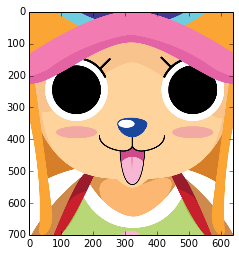

In [15]:
chopper = plt.imread('chopper.png')
print chopper.shape
print chopper.dtype
plt.imshow(chopper)


In [16]:
#python code
import numpy as np
def diff(img, i, j, nc, ioffset, joffset):
    d = 0
    for ic in range(nc):
        d +=(img[i+ioffset,j+joffset,ic] - img[i,j,ic])**2
    return d


def py_sobel(img):
    nx,ny,nc = img.shape[:3]
    ret = np.empty((nx-2,ny-2),dtype=np.float32) #get rid of the boundaries
    for ix in range(1,nx-1):
        print ix,
        for iy in range(1, ny-1):
            s=0
            s+=diff(img, ix, iy, nc, -1, 0) #left
            s+=diff(img, ix, iy, nc, +1, 0)#right
            s+=diff(img, ix, iy, nc, 0, +1)#up
            s+=diff(img, ix, iy, nc, 0, -1)#down
            ret[ix-1,iy-1] = s
    return ret


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

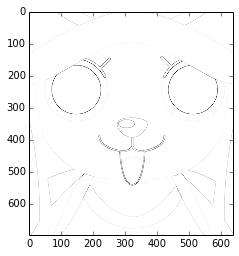

In [17]:
chopper_edge = py_sobel(chopper)
import matplotlib.cm as cm
plt.imshow(chopper_edge, cmap=cm.gray_r)

In [19]:
#try write one yourself before looking at sobel.pyx
pyximport.install(setup_args={'include_dirs': np.get_include()},
                  reload_support=True)
import sobel
x = sobel.sobel(chopper)

NameError: name 'pyximport' is not defined

In [40]:
import matplotlib.cm as cm
plt.imshow(x, cmap=cm.gray_r)

NameError: name 'x' is not defined

##KMean

 (15000, 2)


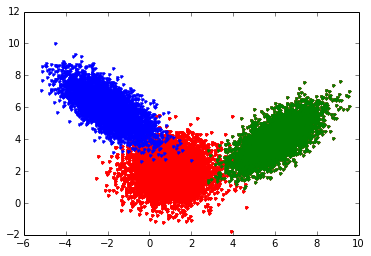

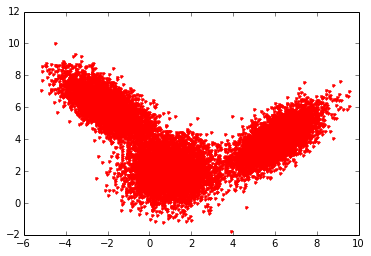

In [41]:
mean = (1, 2)
cov = [[1, 0], [0, 1]]
nx = 5000
x1,y1 = np.random.multivariate_normal(mean, cov, nx).T
mean = (6,4)
cov = [[1, 0.7], [0.7, 1]]
x2,y2 = np.random.multivariate_normal(mean, cov, nx).T
plt.plot(x1,y1,'.r')
plt.plot(x2,y2,'.r')
mean = (-2,6)
cov = [[1, -0.7], [-0.7, 1]]
x3,y3 = np.random.multivariate_normal(mean, cov, nx).T
plt.plot(x1,y1,'.r')
plt.plot(x2,y2,'.g')
plt.plot(x3,y3,'.b')
plt.figure()
plt.plot(x1,y1,'.r')
plt.plot(x2,y2,'.r')
plt.plot(x3,y3,'.r')

xx = np.concatenate([x1,x2,x3])
yy = np.concatenate([y1,y2,y3])
data = np.array([xx,yy]).T
print data.shape

Exercise Cythonize this

In [48]:
%%cython -a
import numpy as np
cimport numpy as np
#Write a general one yourself
def distance(np.ndarray[np.float64_t, ndim=1] a, np.ndarray[np.float64_t, ndim=1] b):
    cdef int i
    cdef np.float64_t d = 0
    for i in range(len(a)):
        d+=(a[i]-b[i])**2
    return d

def findclus(data,r0,r1,r2):
    c = [[],[],[]]
    for i in range(len(data)):
        p = data[i]
        d0 = distance(r0,p)
        d1 = distance(r1,p)
        d2 = distance(r2,p)
        iclus = np.argmin([d0,d1,d2])
        c[iclus].append(i)
    return c

def meanpoint(data, clus):
    nrow, ncol = data.shape
    c = np.zeros(ncol)
    for idata in clus:
        for icol in range(ncol):
            c[icol] += data[idata, icol]
    c = c/len(clus)
    return c
        
        
def kmean3(data, r1, r2, r3):
#     start=[(1,0),(2,4),(4,4)]
#     r1,r2,r3 = start
    for i in range(20):
        c1,c2,c3 = findclus(data, r1,r2,r3)
        r1 = meanpoint(data, c1)
        r2 = meanpoint(data, c2)
        r3 = meanpoint(data, c3)
#         print r1,r2,r3
    return r1,r2,r3        

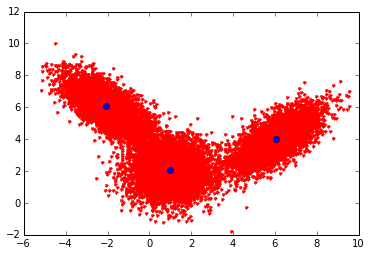

In [51]:
plt.plot(data[:,0],data[:,1],'.r')
%prun r1, r2, r3 = kmean3(data, np.array([1.,0.]), np.array([2.,4.]),np.array([4.,4.]))
plt.plot(r1[0],r1[1],'ob')
plt.plot(r2[0],r2[1],'ob')
plt.plot(r3[0],r3[1],'ob')

In [ ]:
data